# Email Fraud Detection: BERT Model Testing

#### Ross Willett

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Email-Fraud-Detection:-BERT-Model-Testing" data-toc-modified-id="Email-Fraud-Detection:-BERT-Model-Testing-1">Email Fraud Detection: BERT Model Testing</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Ross-Willett" data-toc-modified-id="Ross-Willett-1.0.0.1">Ross Willett</a></span></li></ul></li></ul></li><li><span><a href="#Notebook-Introduction" data-toc-modified-id="Notebook-Introduction-1.1">Notebook Introduction</a></span></li><li><span><a href="#Preparing-the-Data-Set" data-toc-modified-id="Preparing-the-Data-Set-1.2">Preparing the Data Set</a></span></li><li><span><a href="#Loading-and-Testing-the-Model" data-toc-modified-id="Loading-and-Testing-the-Model-1.3">Loading and Testing the Model</a></span><ul class="toc-item"><li><span><a href="#TODO:-REMOVE" data-toc-modified-id="TODO:-REMOVE-1.3.1">TODO: REMOVE</a></span></li><li><span><a href="#REMOVE-ABOVE" data-toc-modified-id="REMOVE-ABOVE-1.3.2">REMOVE ABOVE</a></span></li></ul></li><li><span><a href="#Comparing-Predictions-for-Decision-Tree-Model-and-BERT-Model" data-toc-modified-id="Comparing-Predictions-for-Decision-Tree-Model-and-BERT-Model-1.4">Comparing Predictions for Decision Tree Model and BERT Model</a></span></li><li><span><a href="#Interpretation-of-BERT-Model" data-toc-modified-id="Interpretation-of-BERT-Model-1.5">Interpretation of BERT Model</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.6">Conclusion</a></span></li></ul></li></ul></div>

## Notebook Introduction

In this notebook, the trained fraud email identifier built on the BERT transformer will be loaded and evaluated in terms of performance.

## Preparing the Data Set

In order to test the model, the data set will have to be appropriately separated.

In [299]:
# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import plotting libraries
import matplotlib.pyplot as plt

# Model selection libraries
from sklearn.model_selection import train_test_split

# Model Evaluation Libraries
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Import simple modeling libraries
from sklearn.linear_model import LogisticRegression

# Import Tensor Flow and keras
import tensorflow as tf
from tensorflow import keras

# Import Tensor Flow Hub and Tensor Flow Text (Required libraries for the pre-trained BERT Model)
import tensorflow_hub as hub
import tensorflow_text

# Import shap library to get shapley values
import shap

# Import pickler
import pickle

# Import custom content transformer
from ContentTransformer import Transform_Text_To_Input_Vector

In [300]:
# Configure Pandas to show all columns / rows
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000
# Set column max width larger
pd.set_option('display.max_colwidth', 1000)

In [301]:
# Load X remainder
X_remainder = pd.read_csv('./data/X_remainder.csv')
# Load X test
X_test = pd.read_csv('./data/X_test.csv')
# Load y remainder
y_remainder = pd.read_csv('./data/y_remainder.csv')
# Load y test
y_test = pd.read_csv('./data/y_test.csv')

## Loading and Testing the Model

Now that the data has been appropriately separated, the model can now be loaded and used to predict the classification of the test data.

In [355]:
# Load the saved model into Keras
loaded_model = keras.models.load_model(
    './models/bert_model_20_relu_sig.h5',
    custom_objects={'KerasLayer':hub.KerasLayer},
    compile=False,
)

In [356]:
# Add the compilation parameters for the model (Note this must be done since compile has been set to False)
loaded_model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()]
)

In [304]:
# Get the model prediction probabilities for the test content
y_test_pred = loaded_model.predict(X_test['content'])

78/78 [==============================] - 333s 4s/step


In [308]:
# Binarize the predictions at a threshold of 50% positive
y_test_bin_pred = np.where(y_test_pred >= 0.5, 1, 0)

In [309]:
# Check the accuracy score of the model
accuracy_score(y_test['fraud'].values, y_test_bin_pred.flatten())

0.9669488109633212

Using a standard threshold of 50% to indicate if an email is fraudulent or not results in a test accuracy of 96.7% for the BERT model. This is higher than the best test accuracy for the best decision tree classifier which is 95%. In addition to the higher accuracy, the BERT model would prove better for real world fraudulent email identification due to the fact it is not as reliant upon specific words and can better identify the context of words. The performance of the BERT model will be further examined by looking at its confusion matrix and the types of emails it incorrectly identifies.

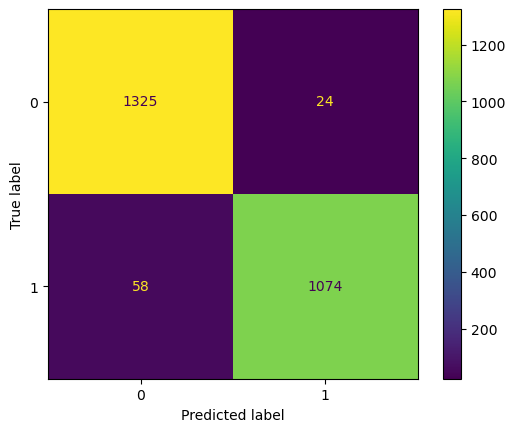

In [310]:
# Initialize the confusion matrix for the model's results
conf_matrix = confusion_matrix(y_test, y_test_bin_pred)
# Initialize the display of the confusion matrix for the model results
conf_disp = ConfusionMatrixDisplay(conf_matrix)
# Plot the confusion matrix
conf_disp.plot()
plt.show()

In [311]:
# Calculate the recall of the model
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1]) * 100
# Calculate the precision of the model
precision = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1]) * 100
# Print the precision and recall of the model
print(f'Recall: {recall}%')
print(f'Precision: {precision}%')

Recall: 94.87632508833921%
Precision: 97.81420765027322%


As demonstrated by the confusion matrix above, the recall of the model is 95% and precision is 98%. These results are both higher than the results of the best Decision Tree model. Next, the incorrect categorizations of the model will be examined.

In [312]:
# Get the X values where the predicted value does not equal the test value
wrong_pred = X_test[y_test_bin_pred.flatten() != y_test['fraud']]

In [313]:
# Get the Y values where the predicted value does not equal the test value
wrong_pred_y = y_test[y_test_bin_pred.flatten() != y_test['fraud']]

In [314]:
# Concatinate the data frames with wrong X and Y predictions
wrong_pred = pd.concat([wrong_pred, wrong_pred_y], axis=1)

In [315]:
# Check the false negative predictions
wrong_pred[wrong_pred['fraud'] == 1].sample(10)

,content,unsecure_link_count,secure_link_count,numbers_count,word_count,fraud
1781,Best Sunny Mail sent from service at,0,0,0,7,1
2284,Untitled Back Relax and Get for What You Think Get to take to per survey Get to participate in focus to per hour Get to try new keep the and get too Get to preview movie to per hour search search search id to cease future click on A,1,0,11,49,1
2461,looking forward to your punctual response Send also your contact phone number for oral Best Peter i jumpy it Directory,1,0,1,20,1
2022,to you My name is and I am an artist I live in with my two four one dog and the love of my life It is definitely a full house I have been doing since I was a small child That me about of experience I in art in high school and took a few college art Most of my work is done in either pencil or air brush mixed with color I have recently added designing and art work on the computer I have been selling my art for the last and have had my work featured on trading and in I have sold and to private from all around the world I am always facing serious when it comes to selling my art works to International they are always offering to pay with an International POSTAL MONEY ORDER which is difficult for me to cash here in I am looking for a representative outside the United Kingdom who will be working for me as a worker and i will be willing to pay for every transaction to you which wouldnt affect your present state of work i need someone who would help me from my outside the united kingdom i m...,0,0,8,363,1
671,NELSON SMITH KINDLY REPLY ME ON MY PRIVATE ADDRESS yahoo,0,0,1,10,1
1730,God be with you Mail sent from service at,0,0,0,9,1
794,From Manager Street Island Marina,0,0,2,5,1
1289,Agricultural Research Institute of Northern,0,0,2,5,1
2365,if you are interested please write back and I will Keep this confidential as you reach me on yahoo Finally please note that this must be next week I look forward to it Barrister and,0,0,1,35,1
941,hurst net enterprise Once you sent a payment to the address at the top of the list along with your note this is VERY important the next thing to do is copy the contents of this page as you be sending it out as an message to at least people although with the legitimate and the different ways of advertising on the the amount of of your mail could well exceed into the or even millions if you wish The more people who join in the more profitable for everyone on the list If you are going to use a list please make sure it is from a reputable source and people who have In These contain of people who have no to these of The mail that you will send out will contain a copy of this document in your new message You can edit and format the message text in any way you want However it best to just leave the text as it is because you want your to be read by everyone who it Delete the mail address at No in the list and move the up one place becomes becomes No in the list will be empty so put YOUR ad...,0,0,103,634,1


Looking at the messages the model identified as false negatives, there appears to be two prominent patterns. The first pattern is that the model does not properly flag fraud emails which tend to be lengthy where the sender pretends to be from an obscure organization or government institution. The other type of fraud emails incorrectly identified are those that tend to be short with no strong indicating words and a link for the user to follow. It is possible the lengthy emails could be properly identified by a larger BERT model with more training, but it is unlikely the short emails could be identified without additional code built to feed this information along with the BERT model into a new model.

In [316]:
# Check the false positive predictions
wrong_pred[wrong_pred['fraud'] == 0].sample(10)

,content,unsecure_link_count,secure_link_count,numbers_count,word_count,fraud
803,Content Disposition Dear member If you can see this you have been to the list as an user To switch to plain text mail go to You are as You up to receive on exclusive and at Wed love to continue to bring you this news however if you wish to remove yourself from this list go to Content Disposition You are as up to receive on exclusive and at Wed love to continue to bring you this news however if you wish to remove yourself from this list Click here Please do not reply to this message If you have any or would like to send feedback to please send an mail to and Corp All reserved,2,0,5,118,0
618,be careful when this one Also that really cute thing that do of leaving their panties on one leg while making love Dare I ask what a girl is Yahoo Sponsor Free Join Now us click yahoo To from this group send an to Your use of Yahoo is subject to yahoo,2,0,4,52,0
2201,am DEPART Private Residence En mute Hotel am ARRIVE Hotel am MEETING FOREIGN MINISTER Suite am PERSONAL STAFF TIME am Private Suite am MEETING FOREIGN MINISTER am Suite am PERSONAL STAFF TIME am Suite MEETING FOREIGN MINISTER Suite STAFF Suite pin MEETING DEPUTY PRIME MINISTER FOREIGN MINISTER Suite STAFF Suite pin DEPART Hotel En route Airport ARRIVE Airport pin DEPART Airport via US En route Nat Airport ARRIVE National Airport DEPART National Airport En route State Department pin ARRIVE State Department OFFICE TIME Secretary Office PRIVATE MEETING BOB Secretary Office DINNER FOR INCOMING SECRETARY GENERAL pin Room th Floor DEPART State Department En route Private Residence ARRIVE Private Residence,0,0,69,109,0
1753,Madam Secretary Thanks so much for the experience of a life time It is my honor to work for you and learn from you See you this,0,0,0,27,0
1887,Does this work for you Statement by the in the men and of the Department of State are mourning the murder of three people connected to Consulate General in One consulate employee was along with and the husband of a employee was also I offer my to the family and of these The safety and security of our personnel and their in and at the world is always our highest priority I have spoken with our Ambassador in and we are working Government of to do everything necessary to protect our people and to ensure that the horrendous are brought to justice These appalling on of our own State Department family are sadly part of a growing tragedy in They underscore the imperative of our continued commitment to work closely with of President to cripple the influence of at work in This is we must shoulder together particularly in border where strong of history common interest bind the and the people closely together,0,0,0,163,0
275,desk is working this issue on your behalf They will be in touch with the sender of the letter The letter you to enter into a bilateral agreement with in order to rectify a Locally in personal tax predicament I happy to call too if you like,0,0,4,47,0
1234,We re the Access Agreement When you enrolled in Business Mobile or you and accepted our Access Agreement An version of the will go into effect on May You can view a summary of and view the This notice is simply to let you know of these you don need to do anything Your continued use or access of Business Mobile or your agreement with these Thank you for choosing Investment and Insurance are Not Insured by the or Any Federal Government Agency Not a Deposit or Other Obligation of or by the Bank or Any Bank Affiliate Subject to Investment Possible Loss of the Principal Amount Security Center Contact Us Investment and are through is a trade name used by Clearing and Financial Network separate registered broker and non bank of Company Deposit by Bank A Member Please do not reply to this ae a,0,0,16,146,0
266,The Public Library Board the library on city of does not a bank loan of up to million and property tax receipts are,0,0,3,23,0
1669,Please print for in color if possible,0,0,0,7,0
181

Examining the messages the model falsely identified as fraud reveals several commonalities. The first of these is that many of the messages falsely flagged typical relate to governments or finances. This makes sense since many fraud emails relate to these subjects. In addition to this, some messages which relate to downloading files or opening links have also been falsely flagged. This also makes sense since fraud emails tend to encourage this type of activity to trick victims into providing sensitive information or download viruses. It may be difficult to train a model to differentiate these types of emails from truly fraudulent ones without incorporating additional information about the sender, but it is possible with more data and training that this could be improved.

## Comparing Predictions for Decision Tree Model and BERT Model

In order to better understand the advantages of the BERT Model, the predictions of the best Decision Tree model will be compared to the predictions of the BERT model for several sample data points. First, the best decision tree model will be loaded and an appropriate function to transform the inputs into a format consumable by this model added. (See `ContentTransformer.py` file for function used to transform inputs)

In [318]:
# Load column transformer model to use text to input vector function
with open('./models/best_dec_tree.pkl', 'rb') as handle:
    dec_tree_model = pickle.load(handle)

In [321]:
# Initialize test input
test_input = '''
Hi,

There was an authorization for $55.00 at TICKETMASTER CANADA HOST on account 1234*****12**** at 8:18 pm ET.

If you didn't do this, please call 1-800-472-6842.

See your transactions, pay bills, transfer funds, send money, and more via Scotia OnLine or Mobile Banking.

'''
# Transform text input to format consumable by Decision Tree model
dec_tree_input = Transform_Text_To_Input_Vector(test_input)
# Get Decision Tree model prediction for % probability email is fraud
dec_tree_prediction = dec_tree_model.predict_proba(dec_tree_input)[0][1] * 100
# Get BERT model prediction for % probability email is fraud
bert_prediction = loaded_model.predict([test_input], verbose=0)[0][0] * 100
# Print prediction percentages for each model
print(f'Decision Tree - Predicted Chance Fraud: {dec_tree_prediction}%')
print(f'BERT Model - Predicted Chance Fraud: {bert_prediction}%')

Decision Tree - Predicted Chance Fraud: 99.47526236881559%
BERT Model - Predicted Chance Fraud: 18.335482478141785%


As demonstrated by the results, the Decision Tree model estimates with 99% certainty that this email is fraudulent whilst the BERT model only assigns an 18% degree of certainty. Although the BERT model is accurate in this case, some fraudulent emails follow a similar format to this legitimate email and for a case like this, additional information may be necessary to ensure the email comes from a valid source. Next, the predictions for a fraud email collected from a personal inbox will be examined.

In [322]:
# Initialize test input
test_input = '''
Amazon.com
         
H͏͏e͏͏l͏͏l͏͏o͏͏,͏͏

W͏͏e͏͏ ͏͏h͏͏a͏͏v͏͏e͏͏ ͏͏t͏͏e͏͏m͏͏p͏͏o͏͏r͏͏a͏͏r͏͏i͏͏l͏͏y͏͏ ͏͏p͏͏l͏͏a͏͏c͏͏e͏͏d͏͏ ͏͏y͏͏o͏͏u͏͏r͏͏ ͏͏A͏͏m͏͏a͏͏z͏͏o͏͏n͏͏ ͏͏a͏͏c͏͏c͏͏o͏͏u͏͏n͏͏t͏͏ ͏͏o͏͏n͏͏ ͏͏h͏͏o͏͏l͏͏d͏͏ ͏͏a͏͏n͏͏d͏͏ ͏͏c͏͏a͏͏n͏͏c͏͏e͏͏l͏͏e͏͏d͏͏ ͏͏a͏͏n͏͏y͏͏ ͏͏p͏͏e͏͏n͏͏d͏͏i͏͏n͏͏g͏͏ ͏͏o͏͏r͏͏d͏͏e͏͏r͏͏s͏͏ ͏͏o͏͏r͏͏ ͏͏s͏͏u͏͏b͏͏s͏͏c͏͏r͏͏i͏͏p͏͏t͏͏i͏͏o͏͏n͏͏s͏͏ ͏͏b͏͏e͏͏c͏͏a͏͏u͏͏s͏͏e͏͏ ͏͏w͏͏e͏͏ ͏͏d͏͏e͏͏t͏͏e͏͏c͏͏t͏͏e͏͏d͏͏ ͏͏u͏͏n͏͏u͏͏s͏͏u͏͏a͏͏l͏͏ ͏͏a͏͏c͏͏t͏͏i͏͏v͏͏i͏͏t͏͏y͏͏ ͏͏o͏͏n͏͏ ͏͏i͏͏t͏͏.͏͏

T͏͏o͏͏ ͏͏r͏͏e͏͏s͏͏t͏͏o͏͏r͏͏e͏͏ ͏͏y͏͏o͏͏u͏͏r͏͏ ͏͏a͏͏c͏͏c͏͏o͏͏u͏͏n͏͏t͏͏,͏͏ ͏͏y͏͏o͏͏u͏͏ ͏͏c͏͏a͏͏n͏͏ ͏͏c͏͏l͏͏i͏͏c͏͏k͏͏ ͏͏t͏͏h͏͏e͏͏ ͏͏b͏͏u͏͏t͏͏t͏͏o͏͏n͏͏ ͏͏b͏͏e͏͏l͏͏o͏͏w͏͏ ͏͏a͏͏n͏͏d͏͏ ͏͏f͏͏o͏͏l͏͏l͏͏o͏͏w͏͏ ͏͏o͏͏n͏͏-͏͏s͏͏c͏͏r͏͏e͏͏e͏͏n͏͏ ͏͏i͏͏n͏͏s͏͏t͏͏r͏͏u͏͏c͏͏t͏͏i͏͏o͏͏n͏͏s͏͏.͏͏ ͏͏O͏͏n͏͏c͏͏e͏͏ ͏͏y͏͏o͏͏u͏͏ ͏͏h͏͏a͏͏v͏͏e͏͏ ͏͏p͏͏r͏͏o͏͏v͏͏i͏͏d͏͏e͏͏d͏͏ ͏͏t͏͏h͏͏e͏͏ ͏͏r͏͏e͏͏q͏͏u͏͏i͏͏r͏͏e͏͏d͏͏ ͏͏i͏͏n͏͏f͏͏o͏͏r͏͏m͏͏a͏͏t͏͏i͏͏o͏͏n͏͏,͏͏ ͏͏w͏͏e͏͏ ͏͏w͏͏i͏͏l͏͏l͏͏ ͏͏r͏͏e͏͏v͏͏i͏͏e͏͏w͏͏ ͏͏i͏͏t͏͏ ͏͏a͏͏n͏͏d͏͏ ͏͏r͏͏e͏͏s͏͏p͏͏o͏͏n͏͏d͏͏ ͏͏w͏͏i͏͏t͏͏h͏͏i͏͏n͏͏ ͏͏2͏͏4͏͏ ͏͏h͏͏o͏͏u͏͏r͏͏s͏͏.͏͏

Y͏͏o͏͏u͏͏ ͏͏c͏͏a͏͏n͏͏n͏͏o͏͏t͏͏ ͏͏a͏͏c͏͏c͏͏e͏͏s͏͏s͏͏ ͏͏y͏͏o͏͏u͏͏r͏͏ ͏͏a͏͏c͏͏c͏͏o͏͏u͏͏n͏͏t͏͏ ͏͏u͏͏n͏͏t͏͏i͏͏l͏͏ ͏͏t͏͏h͏͏i͏͏s͏͏ ͏͏p͏͏r͏͏o͏͏c͏͏e͏͏s͏͏s͏͏ ͏͏i͏͏s͏͏ ͏͏c͏͏o͏͏m͏͏p͏͏l͏͏e͏͏t͏͏e͏͏.͏͏

I͏͏f͏͏ ͏͏y͏͏o͏͏u͏͏ ͏͏d͏͏o͏͏n͏͏'͏͏t͏͏ ͏͏c͏͏o͏͏m͏͏p͏͏l͏͏e͏͏t͏͏e͏͏ ͏͏a͏͏c͏͏c͏͏o͏͏u͏͏n͏͏t͏͏ ͏͏r͏͏e͏͏c͏͏o͏͏v͏͏e͏͏r͏͏y͏͏ ͏͏w͏͏i͏͏t͏͏h͏͏i͏͏n͏͏ ͏͏3͏͏ ͏͏d͏͏a͏͏y͏͏s͏͏,͏͏ ͏͏w͏͏e͏͏ ͏͏w͏͏i͏͏l͏͏l͏͏ ͏͏l͏͏o͏͏c͏͏k͏͏ ͏͏y͏͏o͏͏u͏͏r͏͏ ͏͏a͏͏m͏͏a͏͏z͏͏o͏͏n͏͏ ͏͏a͏͏c͏͏c͏͏o͏͏u͏͏n͏͏t͏͏ ͏͏p͏͏e͏͏r͏͏m͏͏a͏͏n͏͏e͏͏n͏͏t͏͏l͏͏y͏͏.͏͏

W͏͏e͏͏ ͏͏a͏͏r͏͏e͏͏ ͏͏s͏͏o͏͏r͏͏r͏͏y͏͏ ͏͏f͏͏o͏͏r͏͏ ͏͏a͏͏n͏͏y͏͏ ͏͏i͏͏n͏͏c͏͏o͏͏n͏͏v͏͏e͏͏n͏͏i͏͏e͏͏n͏͏c͏͏e͏͏ ͏͏t͏͏h͏͏i͏͏s͏͏ ͏͏m͏͏a͏͏y͏͏ ͏͏h͏͏a͏͏v͏͏e͏͏ ͏͏c͏͏a͏͏u͏͏s͏͏e͏͏d͏͏.͏͏
T͏͏h͏͏a͏͏n͏͏k͏͏ ͏͏y͏͏o͏͏u͏͏ ͏͏f͏͏o͏͏r͏͏ ͏͏y͏͏o͏͏u͏͏r͏͏ ͏͏a͏͏t͏͏t͏͏e͏͏n͏͏t͏͏i͏͏o͏͏n͏͏.͏͏

S͏͏i͏͏n͏͏c͏͏e͏͏r͏͏e͏͏l͏͏y͏͏,͏͏

C͏͏u͏͏s͏͏t͏͏o͏͏m͏͏e͏͏r͏͏ ͏͏S͏͏e͏͏r͏͏v͏͏i͏͏c͏͏e͏͏
A͏͏m͏͏a͏͏z͏͏o͏͏n͏͏.͏͏c͏͏o͏͏m͏

S͏͏i͏͏g͏͏n͏͏-͏͏i͏͏n͏͏ ͏͏t͏͏o͏͏ ͏͏A͏͏m͏͏a͏͏z͏͏o͏͏n͏͏

'''
# Transform text input to format consumable by Decision Tree model
dec_tree_input = Transform_Text_To_Input_Vector(test_input)
# Get Decision Tree model prediction for % probability email is fraud
dec_tree_prediction = dec_tree_model.predict_proba(dec_tree_input)[0][1] * 100
# Get BERT model prediction for % probability email is fraud
bert_prediction = loaded_model.predict([test_input], verbose=0)[0][0] * 100
# Print prediction percentages for each model
print(f'Decision Tree - Chance Fraud: {dec_tree_prediction}%')
print(f'BERT Model - Chance Fraud: {bert_prediction}%')

Decision Tree - Chance Fraud: 2.646744930629669%
BERT Model - Chance Fraud: 96.51289582252502%


Interestingly, the Decision Tree model assigns a very low probability of fraud, whilst the BERT model assigns an almost certain probablity of fraud. This is likely attributable to the fact that this email is not using the specific words the Decision Tree model has associated with fraud, whereas the word-embeddings from the BERT model allow it to better identify the problematic words in this email.

## Interpretation of BERT Model

Due to the complex nature of neural networks, the reasoning behind the results that they produce can be difficult to explain. This remains the case for models like the BERT model produced in this project, however, several methods can be used to help interpret why the model produces the results it does. One such method is the use of Shapley values which can help explain how much individual features (words) contribute to a prediction value. In this report, Shapley values will be generated for common words in a portion of sample data in order to try and provide some interpretability for the model. 

In [128]:
# Initialize masking function used to determine shapley values
masker = shap.maskers.Text()
# Initialize shapley value calculator
explainer = shap.Explainer(loaded_model.predict, masker=masker)

In [290]:
# Get shapley values for words in 100 samples
shap_values = explainer(X_remainder.sample(50, random_state=666)['content'])

1/1 [==============================] - 1s 956ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 651ms/step


Partition explainer:   2%|▌                              | 1/50 [00:00<?, ?it/s]

1/1 [==============================] - 1s 961ms/step


  0%|          | 0/156 [00:00<?, ?it/s]

1/1 [==============================] - 0s 373ms/step


Partition explainer:   6%|█▍                     | 3/50 [01:43<09:38, 12.31s/it]

1/1 [==============================] - 0s 375ms/step


Partition explainer:   8%|█▊                     | 4/50 [01:45<06:13,  8.11s/it]

1/1 [==============================] - 1s 908ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 645ms/step


Partition explainer:  10%|██▎                    | 5/50 [03:03<25:36, 34.15s/it]

1/1 [==============================] - 1s 641ms/step


Partition explainer:  12%|██▊                    | 6/50 [03:07<17:11, 23.45s/it]

1/1 [==============================] - 1s 913ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 657ms/step


Partition explainer:  14%|███▏                   | 7/50 [04:24<29:38, 41.37s/it]

1/1 [==============================] - 1s 912ms/step


  0%|          | 0/210 [00:00<?, ?it/s]

1/1 [==============================] - 0s 389ms/step


Partition explainer:  16%|███▋                   | 8/50 [04:48<25:06, 35.87s/it]

1/1 [==============================] - 1s 891ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 646ms/step


Partition explainer:  18%|████▏                  | 9/50 [06:06<33:25, 48.90s/it]

1/1 [==============================] - 1s 929ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 648ms/step


Partition explainer:  20%|████▍                 | 10/50 [07:23<38:34, 57.85s/it]

1/1 [==============================] - 1s 651ms/step


Partition explainer:  22%|████▊                 | 11/50 [07:25<26:22, 40.57s/it]

1/1 [==============================] - 1s 980ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 647ms/step


Partition explainer:  24%|█████▎                | 12/50 [08:42<32:49, 51.82s/it]

1/1 [==============================] - 1s 648ms/step


Partition explainer:  26%|█████▋                | 13/50 [08:44<22:32, 36.57s/it]

1/1 [==============================] - 1s 980ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 638ms/step


Partition explainer:  28%|██████▏               | 14/50 [09:50<27:17, 45.50s/it]

1/1 [==============================] - 1s 891ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 642ms/step


Partition explainer:  30%|██████▌               | 15/50 [11:07<32:07, 55.07s/it]

1/1 [==============================] - 1s 966ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 649ms/step


Partition explainer:  32%|███████               | 16/50 [12:25<35:00, 61.79s/it]

1/1 [==============================] - 1s 898ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

1/1 [==============================] - 1s 653ms/step


Partition explainer:  34%|███████▍              | 17/50 [12:32<24:55, 45.32s/it]

1/1 [==============================] - 1s 893ms/step


  0%|          | 0/132 [00:00<?, ?it/s]

1/1 [==============================] - 1s 889ms/step


Partition explainer:  36%|███████▉              | 18/50 [12:57<21:00, 39.38s/it]

1/1 [==============================] - 1s 898ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 640ms/step


Partition explainer:  38%|████████▎             | 19/50 [14:15<26:13, 50.74s/it]

1/1 [==============================] - 1s 892ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 642ms/step


Partition explainer:  40%|████████▊             | 20/50 [15:32<29:22, 58.75s/it]

1/1 [==============================] - 1s 888ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 638ms/step


Partition explainer:  42%|█████████▏            | 21/50 [16:49<31:03, 64.24s/it]

1/1 [==============================] - 1s 904ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 641ms/step


Partition explainer:  44%|█████████▋            | 22/50 [18:37<36:04, 77.30s/it]

1/1 [==============================] - 943s 943s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 886ms/step


Partition explainer:  46%|████████▋          | 23/50 [35:30<2:41:10, 358.18s/it]

1/1 [==============================] - 1s 899ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 738ms/step


Partition explainer:  48%|█████████          | 24/50 [36:53<1:59:28, 275.72s/it]

1/1 [==============================] - 1s 1s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 636ms/step


Partition explainer:  50%|████████▌        | 25/50 [1:11:00<5:36:18, 807.13s/it]

1/1 [==============================] - 1s 909ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 643ms/step


Partition explainer:  52%|████████▊        | 26/50 [1:27:36<5:45:31, 863.83s/it]

1/1 [==============================] - 1s 916ms/step


  0%|          | 0/132 [00:00<?, ?it/s]

1/1 [==============================] - 1s 721ms/step


Partition explainer:  54%|█████████▏       | 27/50 [1:27:55<3:53:56, 610.26s/it]

1/1 [==============================] - 1s 912ms/step


  0%|          | 0/462 [00:00<?, ?it/s]

1/1 [==============================] - 1s 644ms/step


Partition explainer:  56%|█████████▌       | 28/50 [1:45:26<4:32:11, 742.36s/it]

1/1 [==============================] - 1s 917ms/step


  0%|          | 0/90 [00:00<?, ?it/s]

1/1 [==============================] - 0s 378ms/step


Partition explainer:  58%|█████████▊       | 29/50 [2:00:52<4:39:10, 797.66s/it]

1/1 [==============================] - 1s 904ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 635ms/step


Partition explainer:  60%|██████████▏      | 30/50 [2:18:30<4:51:55, 875.78s/it]

1/1 [==============================] - 1s 910ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 655ms/step


Partition explainer:  62%|██████████▌      | 31/50 [2:19:48<3:21:32, 636.45s/it]

1/1 [==============================] - 1s 938ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 627ms/step


Partition explainer:  64%|██████████▉      | 32/50 [2:37:07<3:47:07, 757.09s/it]

1/1 [==============================] - 1s 962ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 707ms/step


Partition explainer:  66%|██████████▌     | 33/50 [3:12:11<5:29:01, 1161.24s/it]

1/1 [==============================] - 1s 906ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 638ms/step


Partition explainer:  68%|██████████▉     | 34/50 [3:28:29<4:55:00, 1106.27s/it]

1/1 [==============================] - 1s 906ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 634ms/step


Partition explainer:  70%|███████████▏    | 35/50 [4:01:52<5:43:47, 1375.20s/it]

1/1 [==============================] - 1s 929ms/step


  0%|          | 0/240 [00:00<?, ?it/s]

1/1 [==============================] - 1s 637ms/step


Partition explainer:  72%|████████████▏    | 36/50 [4:02:22<3:46:41, 971.56s/it]

1/1 [==============================] - 1s 944ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 640ms/step


Partition explainer:  74%|████████████▌    | 37/50 [4:03:39<2:32:24, 703.46s/it]

1/1 [==============================] - 1s 941ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 642ms/step


Partition explainer:  76%|████████████▉    | 38/50 [4:13:45<2:14:49, 674.11s/it]

1/1 [==============================] - 0s 372ms/step


Partition explainer:  78%|█████████████▎   | 39/50 [4:13:47<1:26:37, 472.54s/it]

1/1 [==============================] - 1s 911ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 640ms/step


Partition explainer:  80%|█████████████▌   | 40/50 [4:31:32<1:48:22, 650.24s/it]

1/1 [==============================] - 1s 894ms/step


  0%|          | 0/380 [00:00<?, ?it/s]

1/1 [==============================] - 0s 383ms/step


Partition explainer:  82%|█████████████▉   | 41/50 [4:48:14<1:53:21, 755.76s/it]

1/1 [==============================] - 0s 381ms/step


Partition explainer:  84%|██████████████▎  | 42/50 [4:48:19<1:10:43, 530.49s/it]

1/1 [==============================] - 1s 1s/step


  0%|          | 0/210 [00:00<?, ?it/s]

1/1 [==============================] - 0s 378ms/step


Partition explainer:  86%|██████████████▌  | 43/50 [5:05:05<1:18:32, 673.19s/it]

1/1 [==============================] - 1s 999ms/step


  0%|          | 0/110 [00:00<?, ?it/s]

1/1 [==============================] - 1s 642ms/step


Partition explainer:  88%|████████████████▋  | 44/50 [5:05:20<47:33, 475.66s/it]

1/1 [==============================] - 1s 934ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 639ms/step


Partition explainer:  90%|███████████████▎ | 45/50 [5:37:10<1:15:30, 906.02s/it]

1/1 [==============================] - 1s 913ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 643ms/step


Partition explainer:  92%|███████████████▋ | 46/50 [5:53:34<1:01:57, 929.25s/it]

1/1 [==============================] - 1s 910ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 626ms/step


Partition explainer:  94%|███████████████ | 47/50 [6:27:58<1:03:29, 1269.81s/it]

1/1 [==============================] - 1s 907ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 644ms/step


Partition explainer:  96%|█████████████████▎| 48/50 [6:47:09<41:08, 1234.29s/it]

1/1 [==============================] - 1s 921ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 641ms/step


Partition explainer:  98%|█████████████████▋| 49/50 [7:03:39<19:20, 1160.74s/it]

1/1 [==============================] - 1s 907ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 1s 675ms/step


Partition explainer: 100%|███████████████████| 50/50 [7:04:58<00:00, 836.42s/it]

1/1 [==============================] - 1s 954ms/step


  0%|          | 0/156 [00:00<?, ?it/s]

1/1 [==============================] - 1s 963ms/step


Partition explainer: 51it [7:05:19, 510.39s/it]                                 


Now that the Shapley values have been calculated, we can look at what Shapley values were established for the first text sample.

In [295]:
# Look at shapley value contribution for first text sample
shap.plots.text(shap_values[3])

Looking at a breakdown of the Shapley values for the first sample, a pattern of words relating to money and business typically having higher positive Shapley values. The calculated mean of the shapley values for each word will now be examined for all of the samples.

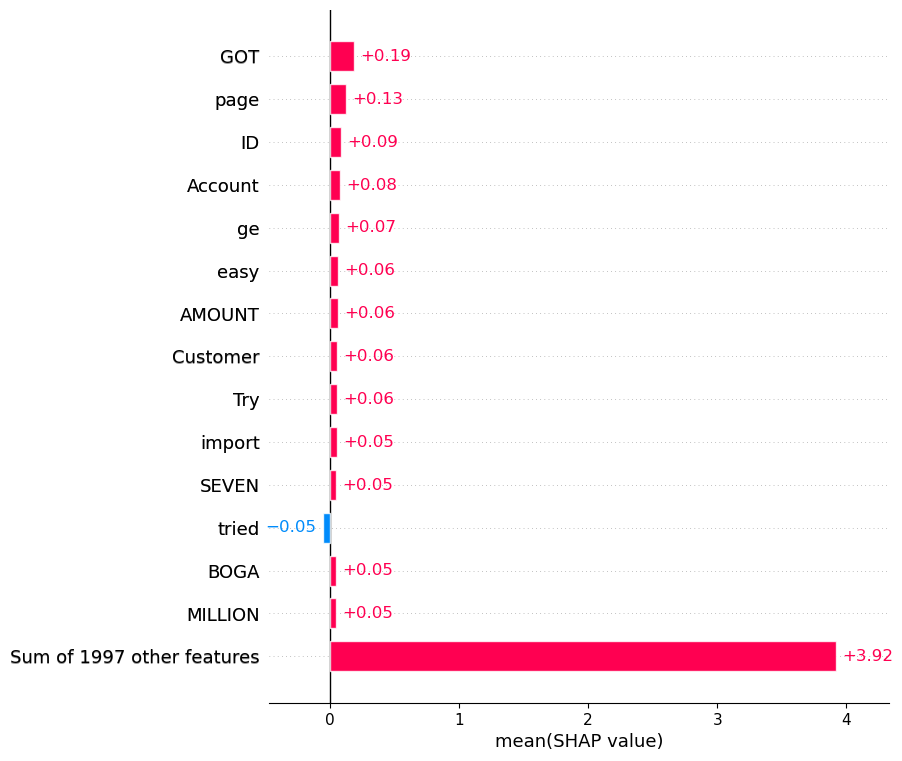

In [297]:
# Plot the mean shapley value associated with each word
shap.plots.bar(shap_values.mean(0)[:, 0], max_display=15)

Looking at the average Shapley values for the 50 samples taken, there appear to be some unusual words with high weights (Likely due to the small sample size), but otherwise the top words seem to relate to money, accounts and finances. Using this information we can determine that the more words relating to money and accounts appear, the more likely the model will predict the message as fraudulent.

## Conclusion

Since the BERT model produces a high accuracy, is more generalizable, and accounts for word contexts, it is the model recommended for use in fraud email detection. The generalizability of this models makes it ideal, as it makes it more adaptable to the constantly changing strategies of the perpetrators of fraud. In addition to this, its ability to establish the relationship between words makes it better for distinguishing between real communications from institutions and criminals pretending to be from these institutions. That said, some legitimate emails are difficult to distinguish from fraud based solely on text content, so any model only relying on that will likely never produce perfect results. In conclusion, although this project proves that a model can be used to identify fraud emails with a high degree of accuracy, additional information (such as the domain of the sender) would likely be needed to be certain if an email is fraudulent or not.